In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os

# 하이퍼파라미터
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 7

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # FER2013은 흑백
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = ImageFolder(root=r'C:\Users\hyi8402\Desktop\실시간 얼굴 감정 검출\DataSet\FER2013\train', transform=transform)
test_data = ImageFolder(root=r'C:\Users\hyi8402\Desktop\실시간 얼굴 감정 검출\DataSet\FER2013\test', transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# 클래스 확인
print("클래스 목록:", train_data.classes)

클래스 목록: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


torch.Size([1, 48, 48])
tensor(3)


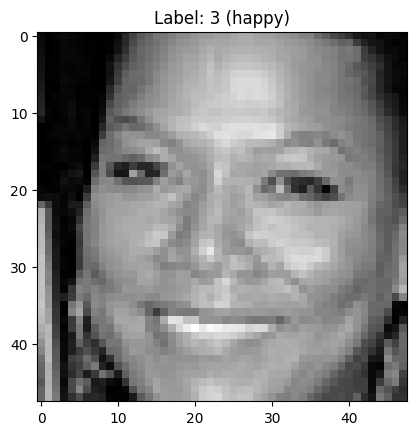

In [12]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

print(images[0].shape)      # torch.Size([1, 48, 48])
print(labels[0])            # 예: tensor(3)
plt.imshow(images[0].squeeze(0), cmap='gray')  # squeeze로 채널 제거
plt.title(f"Label: {labels[0].item()} ({train_data.classes[labels[0]]})")
plt.show()

In [13]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 6x6
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [15]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.5948
Epoch 2/10, Loss: 1.3152
Epoch 3/10, Loss: 1.1899
Epoch 4/10, Loss: 1.0883
Epoch 5/10, Loss: 0.9864
Epoch 6/10, Loss: 0.8953
Epoch 7/10, Loss: 0.7954
Epoch 8/10, Loss: 0.6933
Epoch 9/10, Loss: 0.6006
Epoch 10/10, Loss: 0.5201


In [16]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 59.42%


In [17]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=train_data.classes))


              precision    recall  f1-score   support

       angry       0.45      0.56      0.50       958
     disgust       0.86      0.45      0.59       111
        fear       0.49      0.44      0.46      1024
       happy       0.80      0.78      0.79      1774
     neutral       0.54      0.53      0.53      1233
         sad       0.45      0.46      0.46      1247
    surprise       0.79      0.74      0.76       831

    accuracy                           0.59      7178
   macro avg       0.63      0.57      0.58      7178
weighted avg       0.60      0.59      0.60      7178

